# Furijeove transformacije $-$ obrada zvuka

Učitajmo najpre ulazni *wav* fajl:

In [1]:
from IPython import display
display.Audio(url='data/bonobo.wav')

Ovaj zvuk možemo posmatrati kao signal koji ima svoju frekvenciju uzrokovanja $F_s$ i vrednosti u vremenskom domenu. Izvucimo te informacije iz fajla:

In [2]:
from scipy.io import wavfile

Fs, data = wavfile.read('data/bonobo.wav')
print('Fs =', Fs)
print(data.shape)

Fs = 44100
(1323000, 2)


Vidimo da je $F_s = 441000$ Hz i $N = 1323000$. Ovaj signal ima dve komponente, jer je u pitanju stereo zvuk. Da bismo mogli na njega da primenimo Furijeovu transformaciju, uzmimo srednju vrednost:

In [3]:
data = data.mean(axis=1)
data.shape

(1323000,)

Ukupno vreme trajanja je $T = 30$ s:

In [4]:
N = data.shape[0]
duration = N / Fs
duration

30.0

Razmotrimo kako se zvuk ponaša u prvih pola sekunde:

In [5]:
import numpy as np
from numpy import fft

# broj uzoraka u prvih pola sekunde
n = Fs // 2
# deo singala koji transformisemo
sample = data[:n]
c = fft.fft(sample)
freq = fft.fftfreq(n, 1.0/Fs)

Uzmimo sada samo one frekvencije koje su u intervalu $(0, 1000)$ i prikažimo signal u frekvencijskom domenu koristeći *stem* grafik:

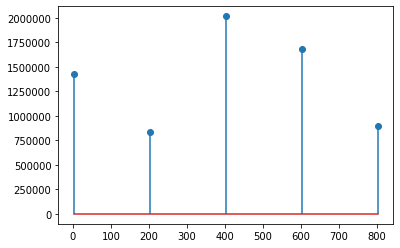

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

mask = (freq > 0) * (freq < 1000)
c_filtered = c[mask]
freq_filtered = freq[mask]
plt.stem(freq_filtered[::100], np.abs(c_filtered[::100]), use_line_collection=True)
plt.show()

**Prozorske funkcije**

U praksi signal najčešće nije periodičan, a periodičnost je zgodna osobina funkcije pri primeni Furijeovih transformacija. Da bi se u praksi taj problem koliko-toliko nadomestio, pribegava se korišćenju **prozorskih funkcija** (eng. *window functions*). One su u krajevima jednake nuli, rastu do polovine intervala, a zatim ponovo opadaju. Sve one zavise od broja uzoraka $n$, a vrednost se nakon transformacije množi sa njima. Prikažimo primer nekoliko njih:

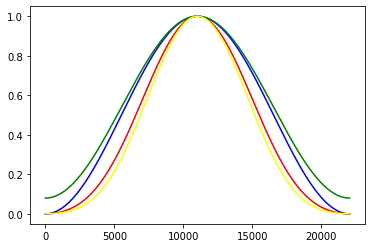

In [7]:
from scipy import signal

plt.plot(np.arange(0,n), signal.windows.blackman(n), color='red')
plt.plot(np.arange(0,n), signal.windows.hann(n), color='blue')
plt.plot(np.arange(0,n), signal.windows.hamming(n), color='green')
# promeniti parametar Kajzerove funkcije i videti kako se signal ponasa
plt.plot(np.arange(0,n), signal.windows.kaiser(n, 10), color='yellow')
plt.show()

Za naš primer ćemo uzeti npr. Kajzerovu funkciju sa parametrom 5:

In [8]:
window = signal.windows.kaiser(n, 5)

**Spektrogram**

Sada ćemo da kreiramo spektrogram zvučnog signala koji razmatramo. Spektrogram predstavlja vizuelnu reprezantaciju zvučnog signala u frekvencijskom domenu. Više o sprektrogramu se može pročitati [ovde](https://en.wikipedia.org/wiki/Spectrogram). Ovde će on biti predstavljen matricom, koja ima onoliko redova koliko ima vremenskih intervala (ovde će to biti 60 redova, jer se merenje vrši na intervalima od po 0.5 s, a ukupno vreme je 30 s) i onoliko kolona koliko ima frekvencija za dati vremenski interval (ovde je nešto smanjen broj u odnosu na početni, jer su filtrirane).

In [9]:
sp_frequencies = freq_filtered.size
sp_time = int(duration // 0.5)
spectrogram = np.zeros((sp_time, sp_frequencies))
spectrogram.shape

(60, 499)

Gore smo razmotrili samo prvi interval od 0.5 s. Sada ćemo proći kroz sve vremenske intervale, primeniti Furijeovu transformaciju, popraviti signal prozorskom funkcijom, a zatim na osnovu toga generisati $i$-ti red spektrograma. Primetimo da smo vrednosti koeficijenata prikazivali na logaritamskoj skali, kako bi se njihov odnos jasnije video (izbaciti `np.log` iz koda i videti kakav je efekat na generisani spektrogram).

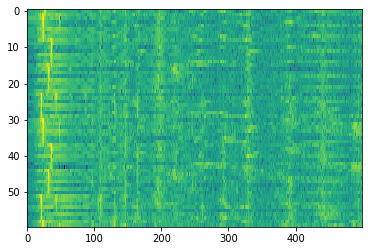

In [10]:
for i in range(sp_time):
    samples = data[i*n : (i+1)*n]
    c = fft.fft(samples) * window
    c_filtered = c[mask]
    fragment = np.log(np.abs(c_filtered))
    spectrogram[i, :] = fragment
    
plt.imshow(spectrogram, aspect='auto')
plt.show()

Sprektrogram smo mogli da generišemo i ugrađenom funcijom na sledeći način:

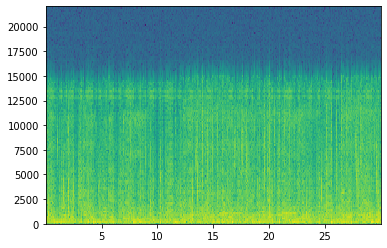

In [11]:
f, t, s = signal.spectrogram(data, Fs)
plt.pcolormesh(t, f, np.log(s))
plt.show()

Ovde frekvencije nisu bile filtrirane kao u ručno generisanom spektrogramu. Povratne vrednosti funkcije `signal.spectrogram` su:

* `f` $-$ niz frekvencija,
* `t` $-$ niz vremena segmenata,
* `s` $-$ vrednosti spektrograma.